In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Plotting style
plt.style.use('seaborn-whitegrid')

sns.set_context("talk") # Makes plots more readable

# Define the player and data file
# You can change this to analyze other players later
PLAYER_NAME_DISPLAY = "Anthony Edwards"
PLAYER_SLUG = "anthony_edwards"
SEASONS = [2022, 2023, 2024] # Matches your processing script

DATA_DIR = Path("./data/new/processed_data/")
input_csv_filename = f"{PLAYER_SLUG}_stats_sentiment_{SEASONS[0]}_{SEASONS[-1]}.csv"
# The filename in your tree is anthony_edwards_stats_plus_sentiment_fullsnap_2022_2024.csv
# or anthony_edwards_stats_plus_sentiment_2022_2024.csv
# Let's use the one from the script you just shared:
input_csv_filename = f"{PLAYER_SLUG}_stats_sentiment_{SEASONS[0]}_{SEASONS[-1]}.csv"
# If your file is named *_stats_plus_sentiment_fullsnap_*, adjust the line above or the one below.
# If the script 'sentimentmerger.py' produced it, the name would be:
# input_csv_filename = f"{PLAYER_SLUG}_stats_plus_sentiment_fullsnap_{SEASONS[0]}_{SEASONS[-1]}.csv"

input_file_path = DATA_DIR / input_csv_filename

print(f"Attempting to load: {input_file_path}")

Attempting to load: data\new\processed_data\anthony_edwards_stats_sentiment_2022_2024.csv


In [5]:
# --- Project Question (Unsupervised Learning Focus) ---

# Main Question:
# "What are the characteristic patterns and relationships between an NBA player's 
#  on-court game statistics and the associated Reddit sentiment metrics (volume, tone, recency) 
#  surrounding their games?"

# Sub-questions to explore:
# 1. Which player performance metrics (e.g., points, efficiency, +/-) show the strongest 
#    correlation with sentiment metrics (mean sentiment, positivity, post volume)?
# 2. Does game outcome (Win/Loss) have a discernible impact on the aggregated sentiment?
# 3. Can we identify distinct "types" or clusters of games based on combined performance 
#    and sentiment profiles?
# 4. How does the volume and recency (delta_days) of Reddit discussion relate to the 
#    sentiment tone and player performance?
# 5. What are some surprising or non-obvious features or relationships in this dataset?

print("Project Question Defined.")

Project Question Defined.


In [6]:
def load_and_preprocess_data(file_path, player_name_display):
    """Loads and preprocesses the combined stats and sentiment data for a player."""
    if not file_path.exists():
        print(f"❌ ERROR: Data file not found at {file_path}")
        print("Please ensure 'process_all_players.py' (or your final merging script) has been run successfully.")
        return None

    print(f"\n--- Loading data for {player_name_display} ---")
    df = pd.read_csv(file_path)
    print(f"Initial rows loaded: {len(df)}")

    # Convert GAME_DATE (original) and game_date (merged) to datetime
    # The `process_all_players.py` script should ensure `game_date` is already datetime.
    # We'll use the `game_date` column added/standardized by the processing script.
    df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    
    # Drop rows where game_date couldn't be parsed (if any)
    df.dropna(subset=['game_date'], inplace=True)

    # Feature Engineering: WL to numeric
    if 'WL' in df.columns:
        df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0 if x == 'L' else np.nan)
        # Drop games that might be ties or have other WL values if any, or handle as needed
        df.dropna(subset=['WIN'], inplace=True) 
        df['WIN'] = df['WIN'].astype(int)
    else:
        print("⚠️ WL column not found. Cannot create WIN feature.")

    # --- CRITICAL FILTER: Only include games with actual sentiment data ---
    # Your `process_all_players.py` fills `post_count` with 0 if no sentiment.
    # The prompt mentions ~10% of games have sentiment scores of 0 (filled).
    # This implies `post_count` would be 0 for those.
    print(f"Rows before filtering on post_count: {len(df)}")
    df_filtered = df[df['post_count'] > 0].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Rows after filtering for post_count > 0: {len(df_filtered)}")
    
    if len(df_filtered) == 0:
        print(f"❌ ERROR: No games found with post_count > 0 for {player_name_display}. Cannot proceed with sentiment analysis.")
        return None
        
    print(f"Filtered data to {len(df_filtered)} games with sentiment (post_count > 0).")
    
    # Select relevant columns for analysis (can be adjusted)
    stats_cols = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS']
    sentiment_cols = ['mean_sentiment', 'min_sentiment', 'max_sentiment', 
                      'pos_share', 'neg_share', 'post_count', 
                      'avg_delta_days', 'min_delta_days', 'max_delta_days']
    
    # Ensure all selected columns exist
    required_cols = stats_cols + sentiment_cols + ['WIN', 'game_date']
    missing_cols = [col for col in required_cols if col not in df_filtered.columns]
    if missing_cols:
        print(f"❌ ERROR: The following required columns are missing: {missing_cols}")
        return None
        
    return df_filtered

# Load data for the selected player
df_player = load_and_preprocess_data(input_file_path, PLAYER_NAME_DISPLAY)

if df_player is not None:
    print("\n--- Data Overview ---")
    df_player.info()
    print("\n--- Sample Data (First 5 rows with sentiment) ---")
    print(df_player.head())
    print("\n--- Descriptive Statistics (Sentiment Features) ---")
    print(df_player[['mean_sentiment', 'pos_share', 'neg_share', 'post_count', 'avg_delta_days']].describe())
    print("\n--- Descriptive Statistics (Key Performance Features) ---")
    print(df_player[['PTS', 'AST', 'REB', 'PLUS_MINUS', 'WIN']].describe())
else:
    print(f"\nCould not load or preprocess data for {PLAYER_NAME_DISPLAY}. Please check file paths and content.")


--- Loading data for Anthony Edwards ---
Initial rows loaded: 237
Rows before filtering on post_count: 237
Rows after filtering for post_count > 0: 27
Filtered data to 27 games with sentiment (post_count > 0).

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 166 to 236
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SEASON_ID           27 non-null     int64         
 1   Player_ID           27 non-null     int64         
 2   Game_ID             27 non-null     int64         
 3   GAME_DATE           27 non-null     object        
 4   MATCHUP             27 non-null     object        
 5   WL                  27 non-null     object        
 6   MIN                 27 non-null     int64         
 7   FGM                 27 non-null     int64         
 8   FGA                 27 non-null     int64         
 9   FG_PCT              27 non-null     flo


--- Univariate Distributions for Anthony Edwards (Games with Sentiment) ---


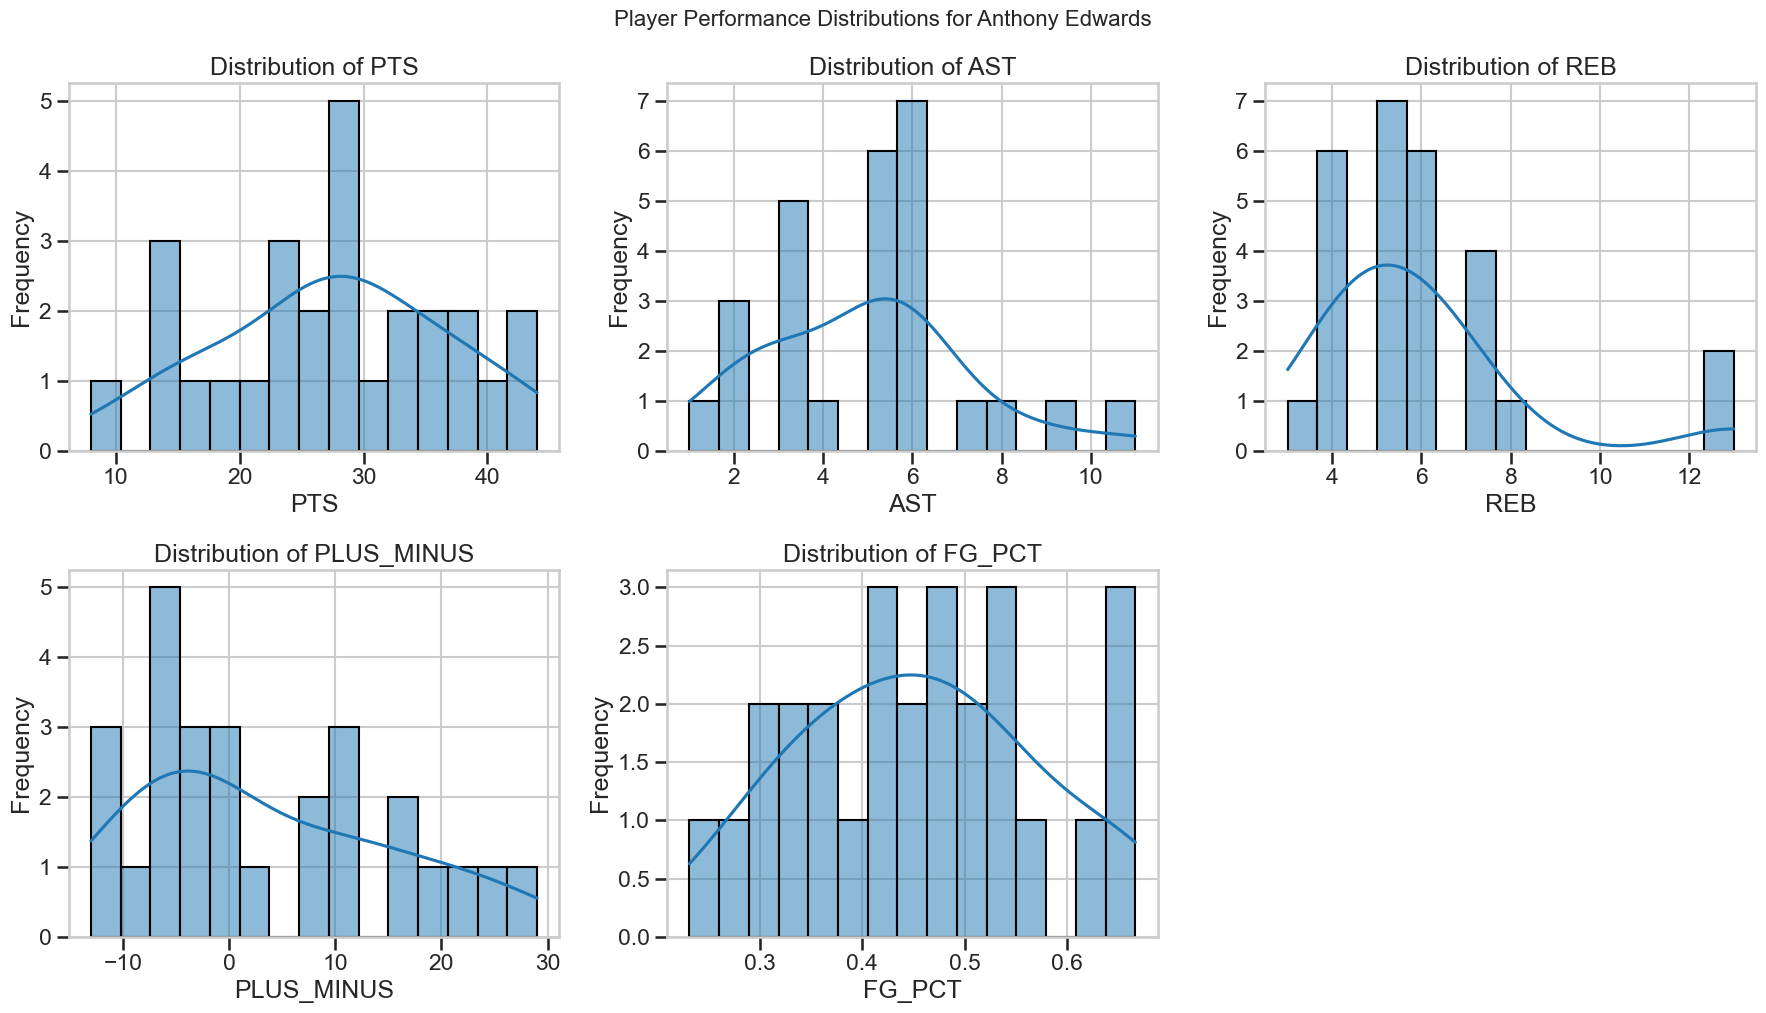

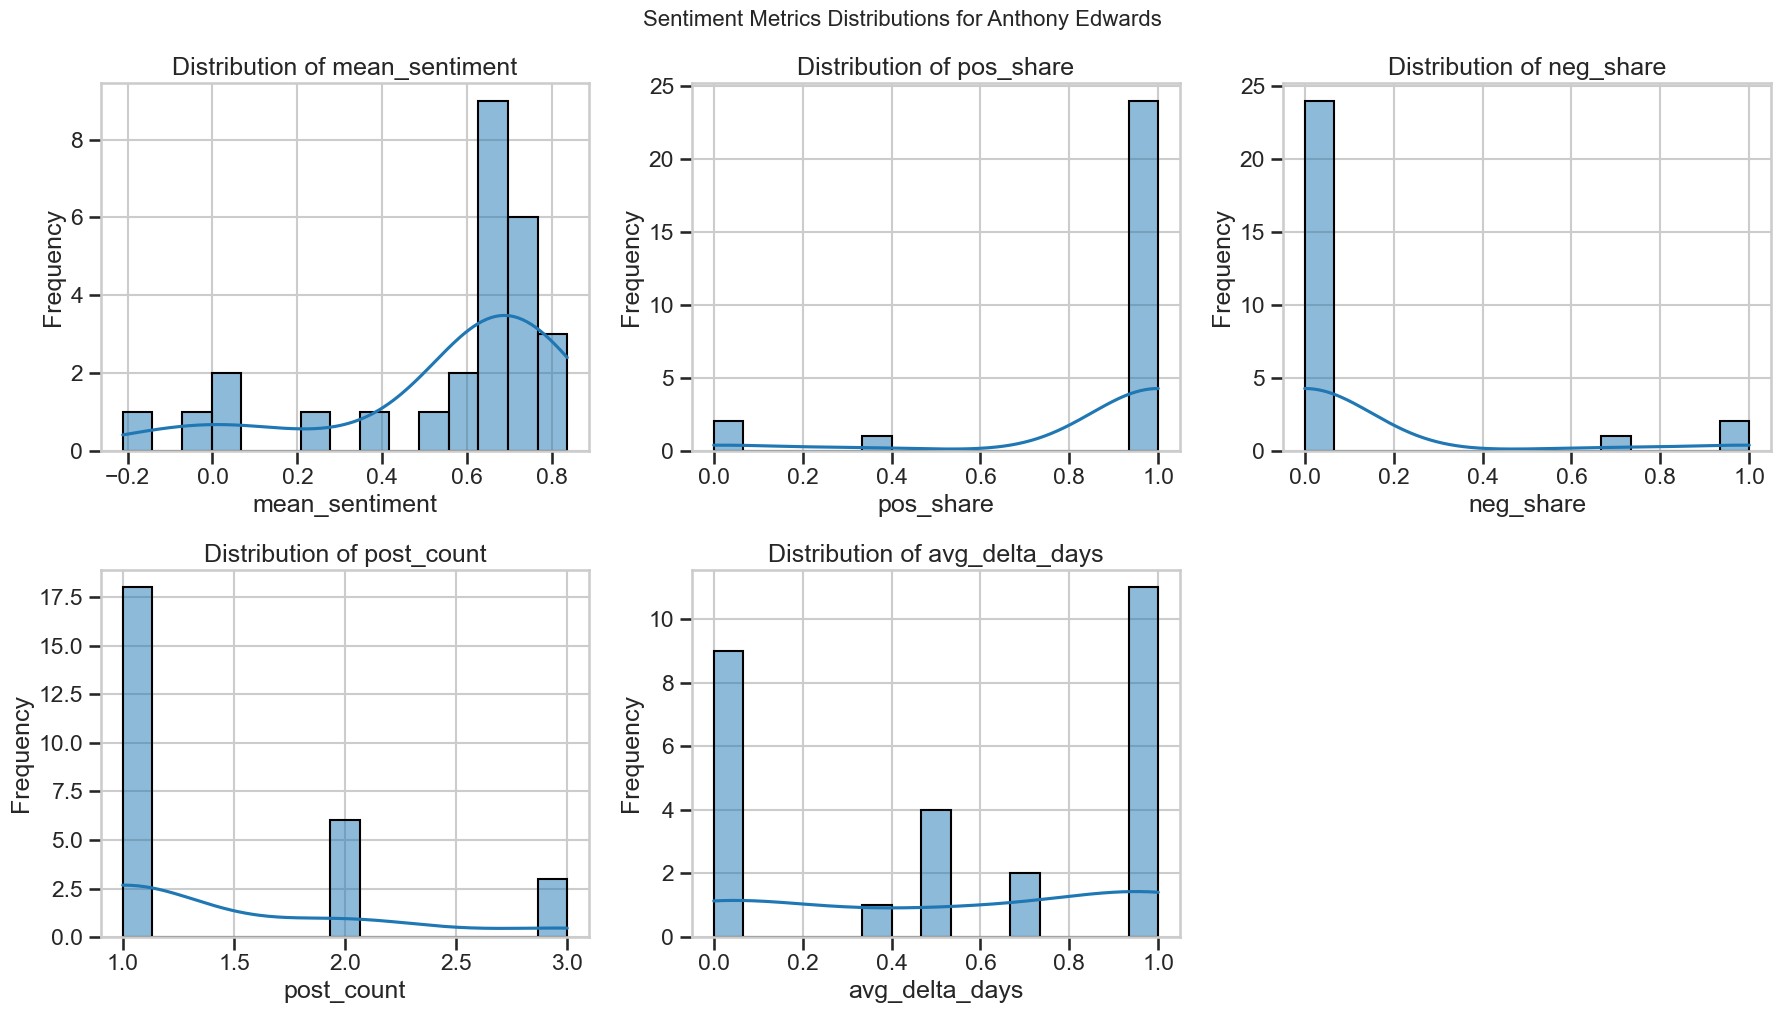

In [7]:
if df_player is not None:
    print(f"\n--- Univariate Distributions for {PLAYER_NAME_DISPLAY} (Games with Sentiment) ---")

    # Columns for histograms
    performance_features_to_plot = ['PTS', 'AST', 'REB', 'PLUS_MINUS', 'FG_PCT']
    sentiment_features_to_plot = ['mean_sentiment', 'pos_share', 'neg_share', 'post_count', 'avg_delta_days']

    # Plotting performance features
    plt.figure(figsize=(18, 10))
    for i, col in enumerate(performance_features_to_plot):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_player[col], kde=True, bins=15)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Player Performance Distributions for {PLAYER_NAME_DISPLAY}', y=1.02, fontsize=16)
    plt.show()

    # Plotting sentiment features
    plt.figure(figsize=(18, 10))
    for i, col in enumerate(sentiment_features_to_plot):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_player[col], kde=True, bins=15)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Sentiment Metrics Distributions for {PLAYER_NAME_DISPLAY}', y=1.02, fontsize=16)
    plt.show()
else:
    print("Data not loaded, skipping univariate distributions.")


--- Correlation Analysis for Anthony Edwards ---


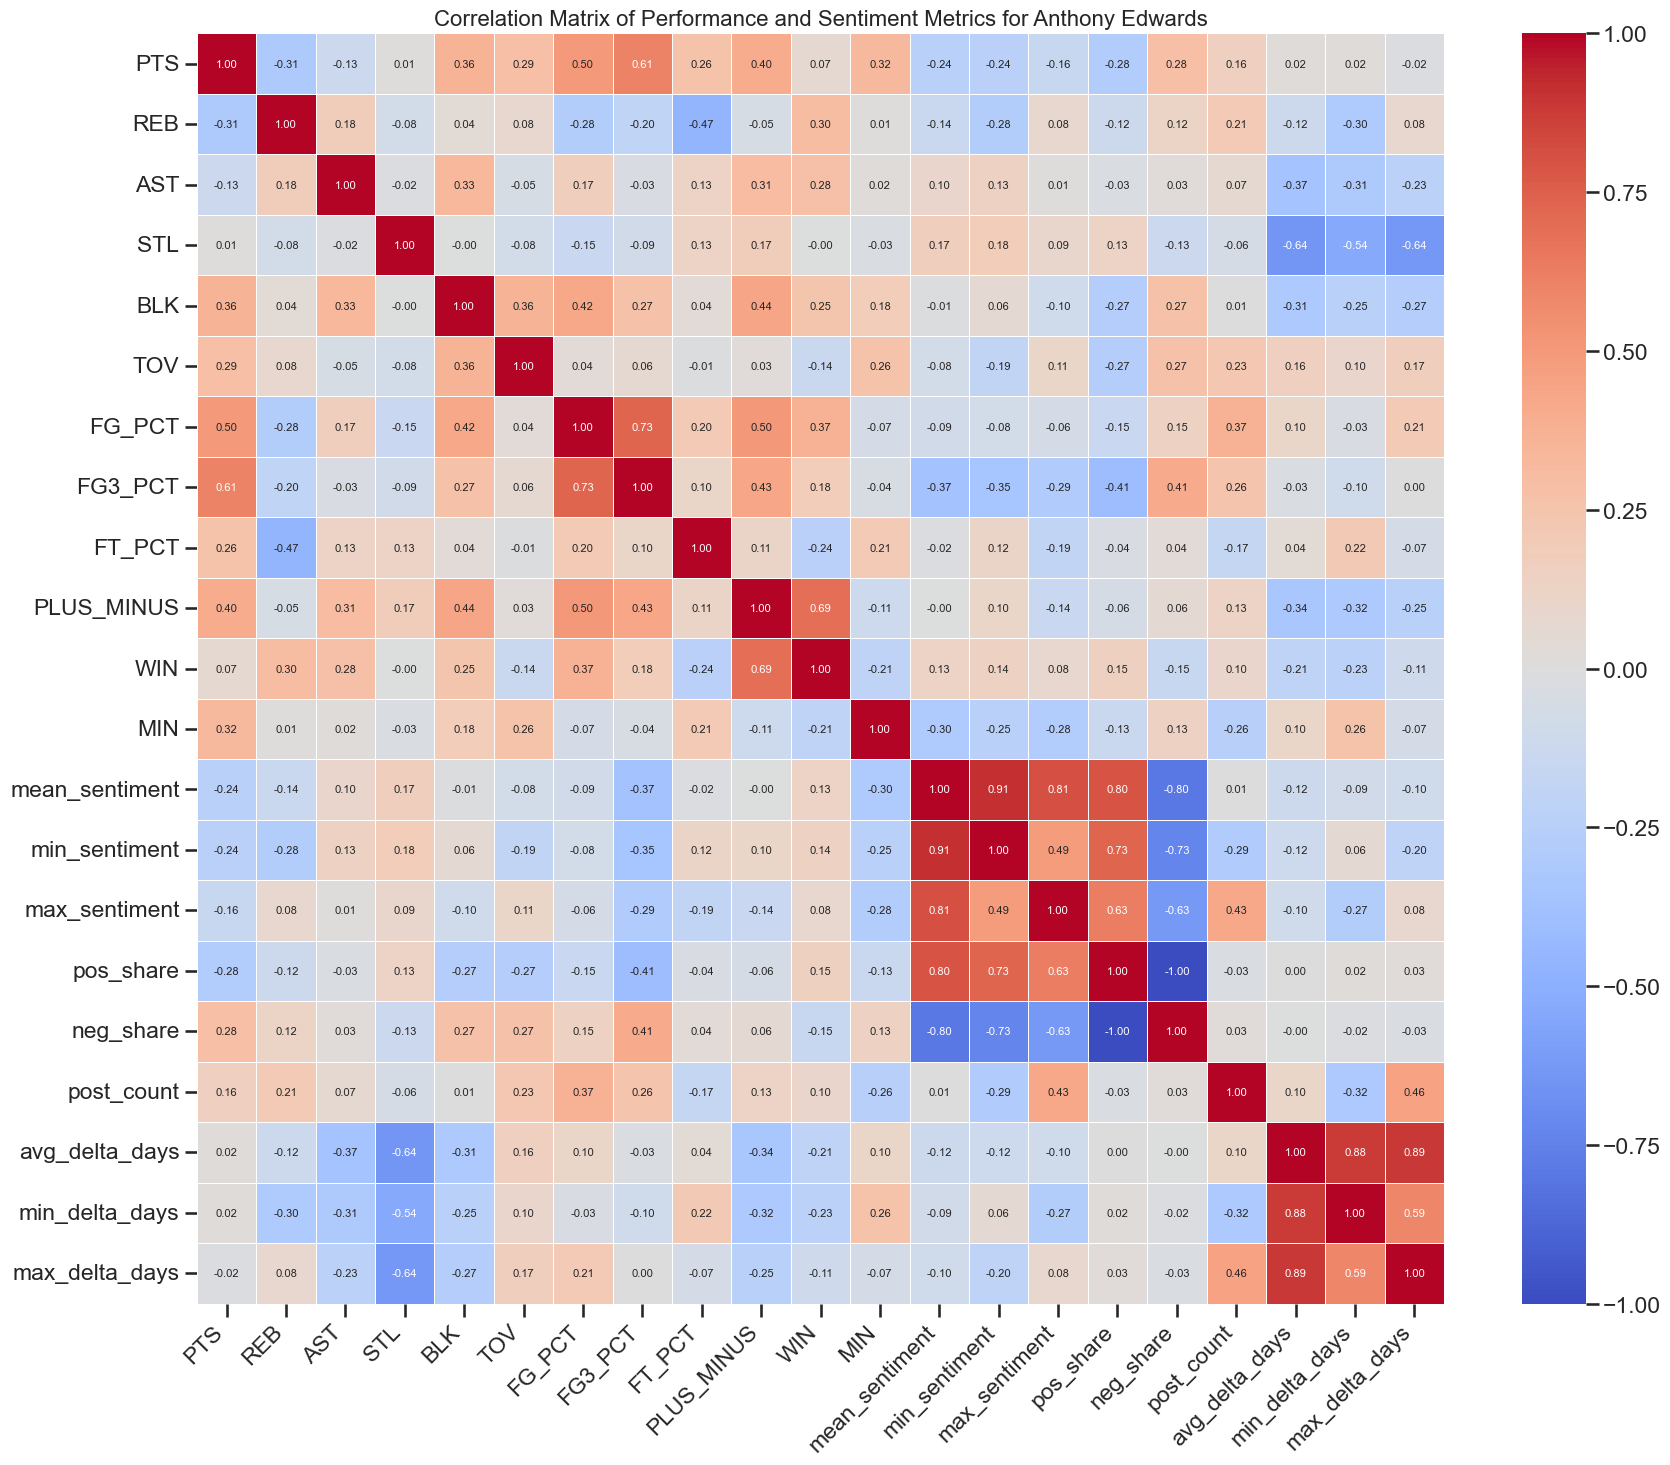


--- Notable Correlations (Example Threshold: abs(correlation) > 0.2) ---
mean_sentiment - min_sentiment: 0.906
avg_delta_days - max_delta_days: 0.890
min_delta_days - avg_delta_days: 0.877
max_sentiment - mean_sentiment: 0.809
mean_sentiment - pos_share: 0.797
min_sentiment - pos_share: 0.732
FG3_PCT - FG_PCT: 0.729
WIN - PLUS_MINUS: 0.690
max_sentiment - pos_share: 0.628
PTS - FG3_PCT: 0.608
max_delta_days - min_delta_days: 0.586
PLUS_MINUS - FG_PCT: 0.505
FG_PCT - PTS: 0.495
min_sentiment - max_sentiment: 0.486
max_delta_days - post_count: 0.459
PLUS_MINUS - BLK: 0.438
FG3_PCT - PLUS_MINUS: 0.432
post_count - max_sentiment: 0.429
FG_PCT - BLK: 0.425
neg_share - FG3_PCT: 0.406
PTS - PLUS_MINUS: 0.402
FG_PCT - WIN: 0.375
post_count - FG_PCT: 0.370
PTS - BLK: 0.361
TOV - BLK: 0.360
BLK - AST: 0.333
PTS - MIN: 0.321
PLUS_MINUS - AST: 0.312
REB - WIN: 0.298
PTS - TOV: 0.288
PTS - neg_share: 0.285
AST - WIN: 0.275
neg_share - BLK: 0.273
neg_share - TOV: 0.267
FG3_PCT - BLK: 0.266
MIN - TO

In [8]:
if df_player is not None:
    print(f"\n--- Correlation Analysis for {PLAYER_NAME_DISPLAY} ---")
    
    # Select numerical features for correlation
    numerical_stats_cols = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'WIN', 'MIN']
    numerical_sentiment_cols = ['mean_sentiment', 'min_sentiment', 'max_sentiment', 'pos_share', 'neg_share', 
                                'post_count', 'avg_delta_days', 'min_delta_days', 'max_delta_days']
    
    correlation_features = [col for col in numerical_stats_cols if col in df_player.columns] + \
                           [col for col in numerical_sentiment_cols if col in df_player.columns]
    
    # Ensure we only try to correlate existing columns
    df_corr = df_player[correlation_features].copy()
    
    # Drop columns that are all NaN if any (can happen if a stat is always missing)
    df_corr.dropna(axis=1, how='all', inplace=True)
    
    # Convert to numeric, coercing errors (e.g. if MIN is 'DNP' in some original logs and not cleaned)
    for col in df_corr.columns:
        df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')
    df_corr.dropna(inplace=True) # Drop rows with NaNs that might result from coercion

    if len(df_corr) > 1 and len(df_corr.columns) > 1:
        correlation_matrix = df_corr.corr()

        plt.figure(figsize=(18, 15))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title(f'Correlation Matrix of Performance and Sentiment Metrics for {PLAYER_NAME_DISPLAY}', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("\n--- Notable Correlations (Example Threshold: abs(correlation) > 0.2) ---")
        # Unstack and filter for interesting correlations
        corr_pairs = correlation_matrix.unstack()
        strong_corrs = corr_pairs[ (abs(corr_pairs) > 0.2) & (abs(corr_pairs) < 1.0) ].sort_values(ascending=False)
        
        # Avoid duplicate pairs (e.g. A-B and B-A)
        seen_pairs = set()
        for (idx1, idx2), value in strong_corrs.items():
            if tuple(sorted((idx1, idx2))) not in seen_pairs:
                print(f"{idx1} - {idx2}: {value:.3f}")
                seen_pairs.add(tuple(sorted((idx1, idx2))))
        if not seen_pairs:
            print("No correlations found above the threshold of 0.2.")
            
    else:
        print("⚠️ Not enough data or columns to compute correlation matrix after cleaning.")
        
else:
    print("Data not loaded, skipping correlation analysis.")


--- Bivariate Scatter Plots for Anthony Edwards ---


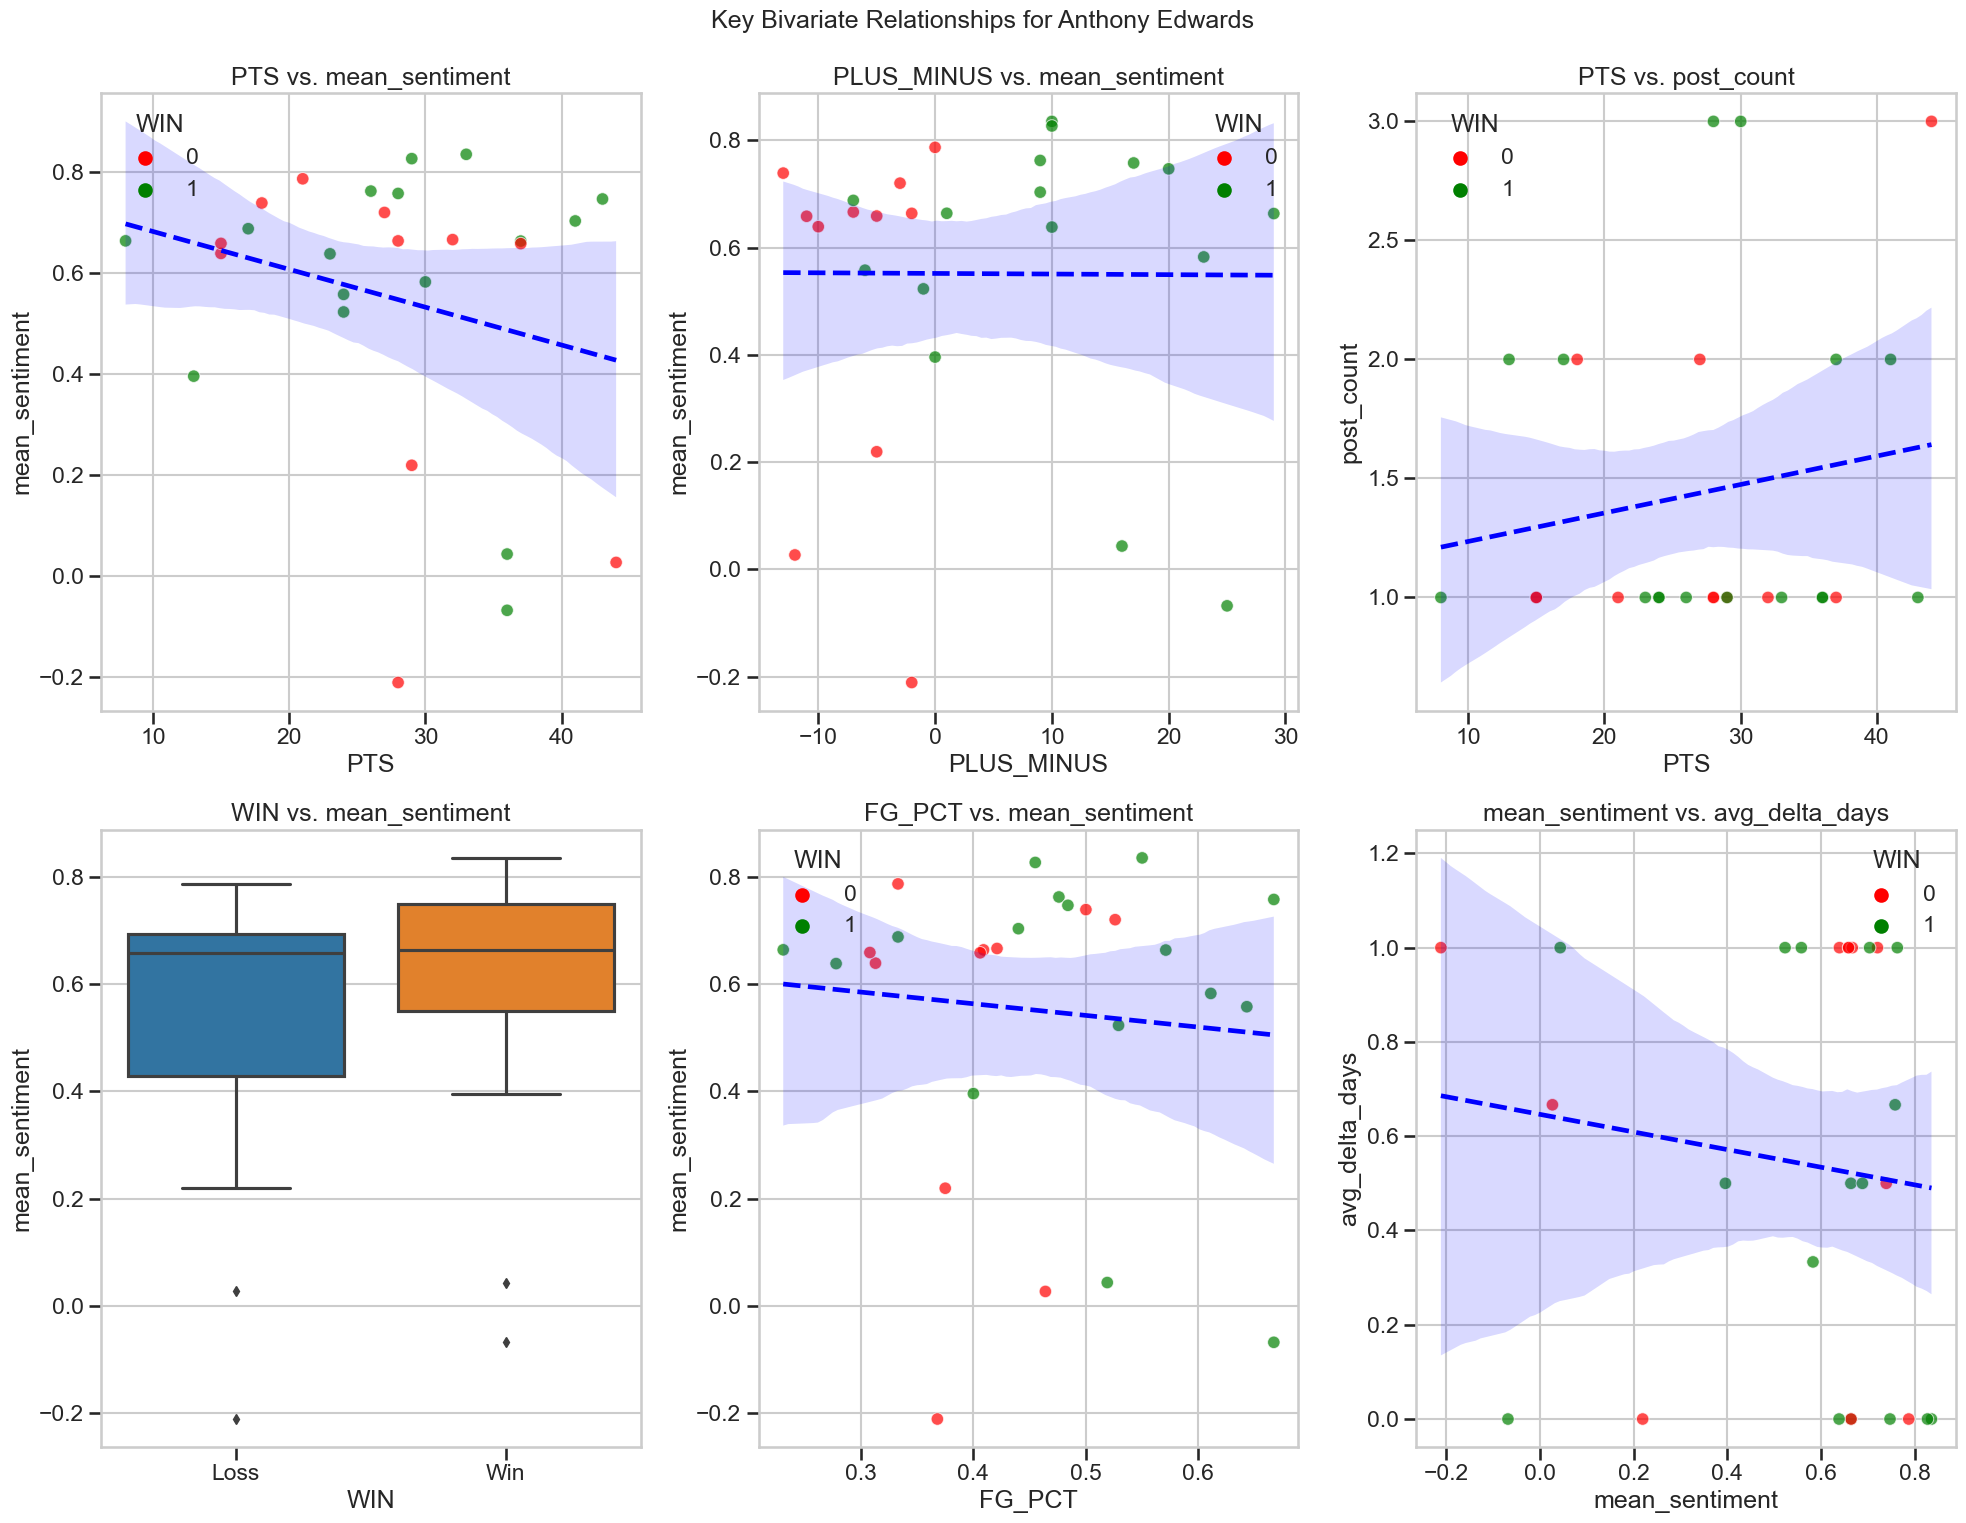

In [9]:
if df_player is not None:
    print(f"\n--- Bivariate Scatter Plots for {PLAYER_NAME_DISPLAY} ---")

    key_relationships = [
        ('PTS', 'mean_sentiment'),
        ('PLUS_MINUS', 'mean_sentiment'),
        ('PTS', 'post_count'),
        ('WIN', 'mean_sentiment'), # For this, WIN should be 0 or 1
        ('FG_PCT', 'mean_sentiment'),
        ('mean_sentiment', 'avg_delta_days')
    ]

    plt.figure(figsize=(20, 15))
    for i, (x_col, y_col) in enumerate(key_relationships):
        if x_col in df_player.columns and y_col in df_player.columns:
            plt.subplot(2, 3, i + 1)
            if x_col == 'WIN': # Use a boxplot or stripplot for categorical WIN vs continuous sentiment
                 sns.boxplot(x=df_player[x_col].astype(int), y=df_player[y_col])
                 plt.xticks([0,1], ['Loss', 'Win'])
            else:
                sns.scatterplot(data=df_player, x=x_col, y=y_col, hue='WIN', palette={0: 'red', 1: 'green'}, alpha=0.7)
                # Add a regression line
                sns.regplot(data=df_player, x=x_col, y=y_col, scatter=False, color='blue', line_kws={'linestyle':'--'})
            plt.title(f'{x_col} vs. {y_col}')
        else:
            print(f"Skipping plot for {x_col} vs {y_col} as one or both columns are missing.")
            
    plt.tight_layout()
    plt.suptitle(f'Key Bivariate Relationships for {PLAYER_NAME_DISPLAY}', y=1.02, fontsize=18)
    plt.show()
else:
    print("Data not loaded, skipping bivariate plots.")

In [10]:
if df_player is not None:
    print(f"\n--- Initial Analysis and Interpretation for {PLAYER_NAME_DISPLAY} ---")
    print("""
    Based on the visualizations and correlation matrix above:

    1. Observe the distributions:
       - Are player stats (PTS, AST, etc.) normally distributed or skewed? 
       - How is sentiment (mean_sentiment, pos_share) distributed? Is it mostly neutral, or skewed positive/negative?
       - How many posts are typically associated with a game (post_count)?
       - What's the typical delta_days? Are most posts very close to game day?

    2. Analyze Correlations:
       - Which performance stats have the strongest positive/negative correlation with `mean_sentiment`? 
         (e.g., Does higher PTS correlate with more positive sentiment? Do more TOV correlate with negative sentiment?)
       - How does `PLUS_MINUS` (a proxy for on-court impact) relate to sentiment?
       - Is there a correlation between `WIN` (1 for win, 0 for loss) and sentiment metrics like `mean_sentiment` or `pos_share`?
       - How does `post_count` (volume of discussion) correlate with performance (e.g., PTS) or sentiment tone?
       - Does `avg_delta_days` (recency of posts) correlate with the strength or direction of `mean_sentiment`?

    3. Note Surprising Features/Relationships:
       - Were there any correlations you expected but didn't find, or vice-versa?
       - Did any features show unexpectedly strong or weak relationships?
         (e.g., "Surprisingly, FG_PCT showed only a weak correlation with mean_sentiment, suggesting that efficient scoring 
          alone might not drive positive discussion as much as raw point totals or game outcome.")
       - "The volume of posts (`post_count`) appears more strongly correlated with `PTS` than `mean_sentiment` is, suggesting
          high-scoring games generate discussion, but that discussion isn't always proportionally more positive."
          
    4. What features seem to matter most in the relationship between performance and sentiment?
       - (This is a primary part of answering your unsupervised learning question)

    Consider specific examples from the plots:
    - "The scatter plot of PTS vs. mean_sentiment shows a slight upward trend, indicating higher point totals are generally associated with more positive sentiment, though there's considerable variance."
    - "The box plot for WIN vs. mean_sentiment shows that games won by {PLAYER_NAME_DISPLAY} tend to have a [higher/lower/similar] median sentiment score compared to losses."

    (This cell is for your textual analysis. Add your specific observations here after running the above cells.)
    """)
else:
    print("Data not loaded. Cannot perform interpretation.")


--- Initial Analysis and Interpretation for Anthony Edwards ---

    Based on the visualizations and correlation matrix above:

    1. Observe the distributions:
       - Are player stats (PTS, AST, etc.) normally distributed or skewed? 
       - How is sentiment (mean_sentiment, pos_share) distributed? Is it mostly neutral, or skewed positive/negative?
       - How many posts are typically associated with a game (post_count)?
       - What's the typical delta_days? Are most posts very close to game day?

    2. Analyze Correlations:
       - Which performance stats have the strongest positive/negative correlation with `mean_sentiment`? 
         (e.g., Does higher PTS correlate with more positive sentiment? Do more TOV correlate with negative sentiment?)
       - How does `PLUS_MINUS` (a proxy for on-court impact) relate to sentiment?
       - Is there a correlation between `WIN` (1 for win, 0 for loss) and sentiment metrics like `mean_sentiment` or `pos_share`?
       - How does `po


--- Sentiment Analysis by Game Outcome (Win/Loss) for Anthony Edwards ---


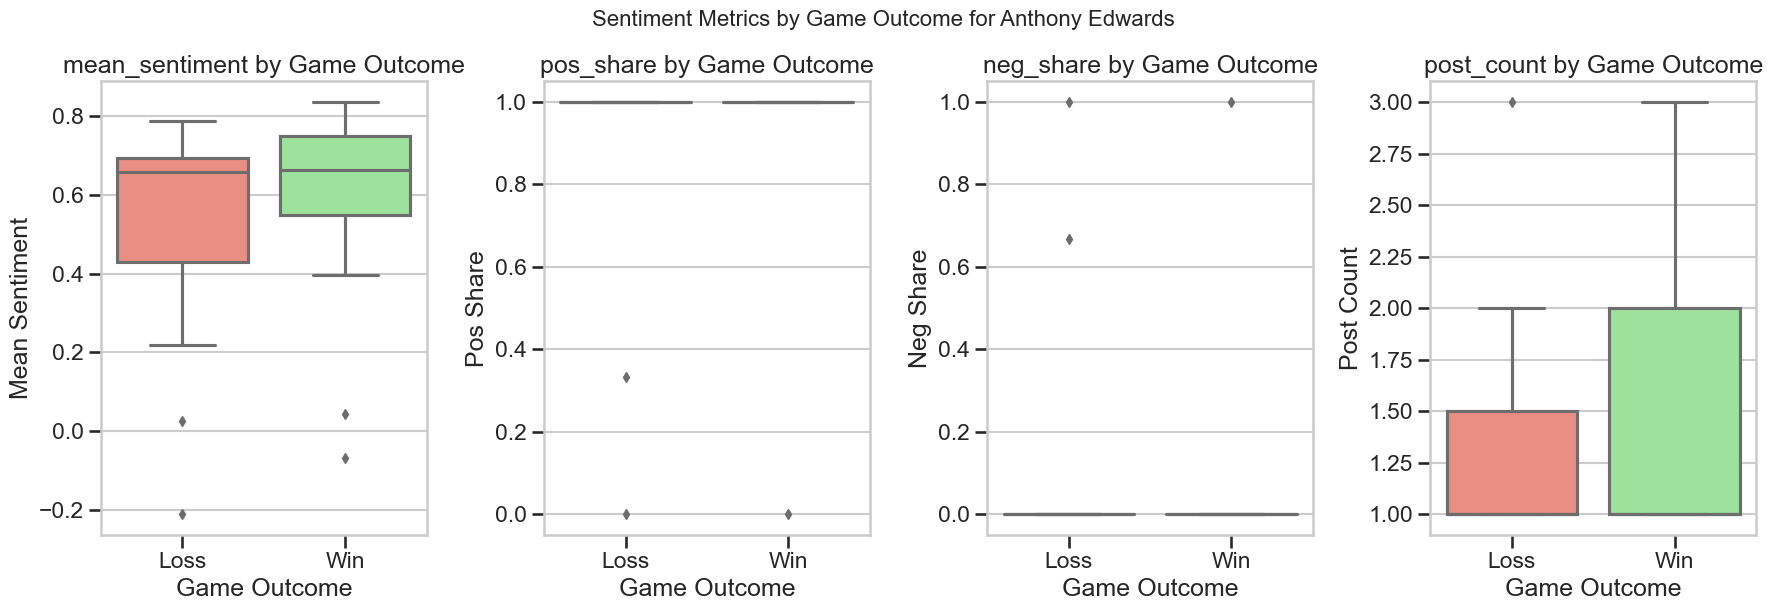


--- Statistical Comparison (Example: Mean Sentiment for Wins vs. Losses) ---
Mean sentiment on Wins: 0.583 (Std: 0.259, Count: 16)
Mean sentiment on Losses: 0.506 (Std: 0.335, Count: 11)


In [11]:
if df_player is not None and 'WIN' in df_player.columns:
    print(f"\n--- Sentiment Analysis by Game Outcome (Win/Loss) for {PLAYER_NAME_DISPLAY} ---")

    plt.figure(figsize=(18, 6))

    sentiment_metrics_for_outcome = ['mean_sentiment', 'pos_share', 'neg_share', 'post_count']

    for i, metric in enumerate(sentiment_metrics_for_outcome):
        if metric in df_player.columns:
            plt.subplot(1, len(sentiment_metrics_for_outcome), i + 1)
            sns.boxplot(x='WIN', y=metric, data=df_player, palette={0: 'salmon', 1: 'lightgreen'})
            plt.title(f'{metric} by Game Outcome')
            plt.xticks([0, 1], ['Loss', 'Win'])
            plt.xlabel('Game Outcome')
            plt.ylabel(metric.replace('_', ' ').title())
        else:
            print(f"Skipping plot for {metric} by Game Outcome as column is missing.")


    plt.tight_layout()
    plt.suptitle(f'Sentiment Metrics by Game Outcome for {PLAYER_NAME_DISPLAY}', y=1.03, fontsize=16)
    plt.show()

    print("\n--- Statistical Comparison (Example: Mean Sentiment for Wins vs. Losses) ---")
    if 'mean_sentiment' in df_player.columns:
        wins_sentiment = df_player[df_player['WIN'] == 1]['mean_sentiment']
        losses_sentiment = df_player[df_player['WIN'] == 0]['mean_sentiment']

        print(f"Mean sentiment on Wins: {wins_sentiment.mean():.3f} (Std: {wins_sentiment.std():.3f}, Count: {len(wins_sentiment)})")
        print(f"Mean sentiment on Losses: {losses_sentiment.mean():.3f} (Std: {losses_sentiment.std():.3f}, Count: {len(losses_sentiment)})")
        
        # You could add a t-test here if you want to be more formal,
        # but for unsupervised, describing the difference is often sufficient.
        # from scipy.stats import ttest_ind
        # if len(wins_sentiment) > 1 and len(losses_sentiment) > 1:
        #     stat, p_value = ttest_ind(wins_sentiment.dropna(), losses_sentiment.dropna(), equal_var=False) # Welch's t-test
        #     print(f"T-test for mean_sentiment (Wins vs Losses): p-value = {p_value:.4f}")
        # else:
        #     print("Not enough data for a t-test.")
    else:
        print("mean_sentiment column not found for statistical comparison.")
else:
    print("Data not loaded or 'WIN' column missing, skipping sentiment by game outcome.")